### 1- Import the libraries

In [29]:
import pandas  as pd
import numpy as np
import pandas as pd
#from easypreprocessing import EasyPreProcessing
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
import scipy.stats as stats

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import numpy as np
import datetime
import pandas as pd
import sklearn as sk
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
from sklearn.metrics import mean_squared_error
from numpy import sqrt

### 2- Load the data

In [30]:
data = pd.read_csv('/Users/alijanehsan/Downloads/Final_project/merge.csv', index_col =0)

In [31]:
data.head()

,date,item_code,quantity,unit_price_vat_excl,unit_cogs,unit_rrp_vat_excl,department,site,Revenue,country,...,gender,age,color,size,kids,men,unisex,women,day,month
0,2022-01-14,ZB00245086,1,107.443868,63.815891,126.367186,E-COMMER,top4running.at,107.443868,Austria,...,men,adults,White,44,0,1,0,0,Friday,January
1,2021-12-09,ZB00245086,1,98.582325,63.816279,129.458420,E-COMMER,top4running.it,98.582325,Italy,...,men,adults,White,44,0,1,0,0,Thursday,December
2,2021-12-08,ZB00245086,1,100.182074,63.815891,131.559296,E-COMMER,top4running.at,100.182074,Austria,...,men,adults,White,44,0,1,0,0,Wednesday,December
3,2021-12-04,ZB00245086,1,98.350139,63.816279,129.153514,E-COMMER,top4running.it,98.350139,Italy,...,men,adults,White,44,0,1,0,0,Saturday,December
4,2021-11-14,ZB00245086,1,99.296899,63.815891,130.396884,E-COMMER,top4running.at,99.296899,Austria,...,men,adults,White,44,0,1,0,0,Sunday,November


### 3- Get the data in daily format

In [32]:
def daily_data(data, time_period='day', revenue='net'):
    time_periods = {
        'day': 'D',
        'week': 'W',
        'month': 'M'}
    
    revenue_cat = {
        'net':'Revenue'}
    data['date'] = pd.to_datetime(data['date'])
    data = data.set_index('date')
    data = data[revenue_cat[revenue]].resample(time_periods[time_period]).sum()
    data = pd.DataFrame(data).reset_index()
    return data

In [33]:
df_d = daily_data(data)
df_d.columns=['ds', 'y']
df_d.ds=pd.to_datetime(df_d['ds'])
df_d.sort_values('ds')
df_d.head()

,ds,y
0,2019-06-01,2148.358325
1,2019-06-02,81.967125
2,2019-06-03,776.005424
3,2019-06-04,52835.931945
4,2019-06-05,48665.642130


### 4- Check the data, if it is not stationary, make it stationary

In [34]:
plot_data = [
    go.Scatter(
        x=df_d['ds'],
        y=df_d['y'],
    )
]
plot_layout = go.Layout(
        title='daily Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## Check with Dicky-fuller test as well

In [35]:
from statsmodels.tsa.stattools import adfuller
print("Observations of Dickey-fuller test")
dftest = adfuller(df_d['y'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                  -3.692076
p-value                          0.004226
#lags used                      22.000000
number of observations used    936.000000
critical value (1%)             -3.437356
critical value (5%)             -2.864633
critical value (10%)            -2.568417
dtype: float64


The data is already stationary

### 5- Prepare and convert  data into  supervised learning format

In [37]:
df_d

,ds,y
0,2019-06-01,2148.358325
1,2019-06-02,81.967125
2,2019-06-03,776.005424
3,2019-06-04,52835.931945
4,2019-06-05,48665.642130
...,...,...
954,2022-01-10,81915.246728
955,2022-01-11,81286.024654
956,2022-01-12,72409.069070
957,2022-01-13,65040.299956


In [44]:

df_supervised = df_d.copy(deep = True)
#adding lags
for inc in range(1,30):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['y'].shift(inc)

#drop null values
#df_supervised = df_supervised.dropna().reset_index()
df_supervised

,ds,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29
0,2019-06-01,2148.358325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-06-02,81.967125,2148.358325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-06-03,776.005424,81.967125,2148.358325,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-06-04,52835.931945,776.005424,81.967125,2148.358325,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-06-05,48665.642130,52835.931945,776.005424,81.967125,2148.358325,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,2022-01-10,81915.246728,74630.808300,64510.163134,68775.154411,68995.085914,72276.903623,66043.278353,70944.441344,64709.212130,...,62277.259005,74189.906316,65972.268064,63251.835670,80125.294628,101656.638757,134822.667673,139005.617297,135630.643604,132035.159428
955,2022-01-11,81286.024654,81915.246728,74630.808300,64510.163134,68775.154411,68995.085914,72276.903623,66043.278353,70944.441344,...,49271.044139,62277.259005,74189.906316,65972.268064,63251.835670,80125.294628,101656.638757,134822.667673,139005.617297,135630.643604
956,2022-01-12,72409.069070,81286.024654,81915.246728,74630.808300,64510.163134,68775.154411,68995.085914,72276.903623,66043.278353,...,49360.806055,49271.044139,62277.259005,74189.906316,65972.268064,63251.835670,80125.294628,101656.638757,134822.667673,139005.617297
957,2022-01-13,65040.299956,72409.069070,81286.024654,81915.246728,74630.808300,64510.163134,68775.154411,68995.085914,72276.903623,...,40654.557970,49360.806055,49271.044139,62277.259005,74189.906316,65972.268064,63251.835670,80125.294628,101656.638757,134822.667673


In [46]:
df_supervised = df_supervised.dropna()

In [48]:
df_supervised.shape

(930, 31)

In [ ]:
x1, x2, x3, x4,x5, x6, x7, y = df_d['day_1'], df_d['day_2'], df_d['day_3'], df_d['day_4'], df_d['day_5'], df_d['day_6'], df_d['day_7'], df_d['y']
x1, x2, x3, x4, x5, x6, x7, y = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6), np.array(x7), np.array(y)
x1, x2, x3, x4, x5, x6, x7, y = x1.reshape(-1,1), x2.reshape(-1,1), x3.reshape(-1,1), x4.reshape(-1,1),x5.reshape(-1,1), x6.reshape(-1,1),x7.reshape(-1,1), y.reshape(-1,1)

split_percentage = 15
test_split = int(len(df_d)*(split_percentage/100))
x = np.concatenate((x1, x2, x3, x4,x5, x6, x7), axis=1)
X_train,X_test,y_train,y_test = x[:-test_split],x[-test_split:],y[:-test_split],y[-test_split:]

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(810, 7)
(142, 7)
(810, 1)
(142, 1)


### Scale the data

In [ ]:
#apply Min Max Scaler
#import MinMaxScaler and create a new dataframe
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X_train)
# reshape training set
train_set = X_train.reshape(X_train.shape[0], X_train.shape[1])
x_train_scaled = scaler.transform(X_train)


scaler = scaler.fit(X_test)
# reshape training set
test_set = X_test.reshape(X_test.shape[0], X_test.shape[1])
test_set_scaled = scaler.transform(X_test)


scaler = scaler.fit(y_train)
# reshape training set
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
y__train_scaled = scaler.transform(y_train)


scaler = scaler.fit(y_test)
# reshape training set
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
y__train_scaled = scaler.transform(y_test)

## XGboost model

In [52]:
import xgboost
xgb_regressor = xgboost.XGBRegressor()
xgb_regressor.fit()



TypeError: fit() missing 1 required positional argument: 'y'

In [ ]:
y_pred = xgb_regressor.predict(X_test)

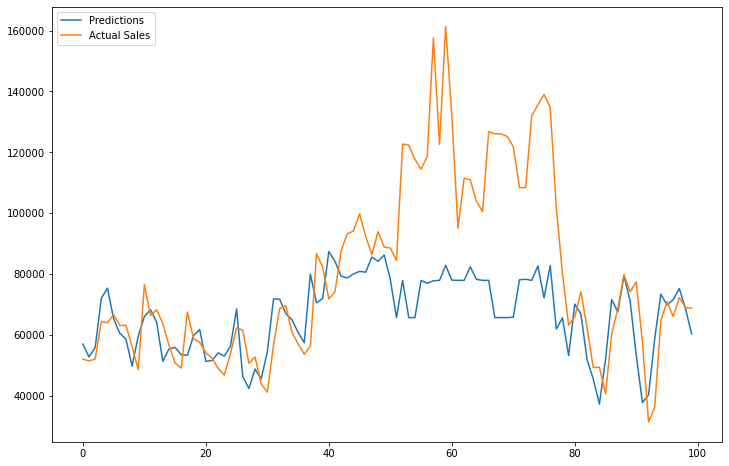

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(y_pred[-100:], label='Predictions')
plt.plot(y_test[-100:], label='Actual Sales')
plt.legend(loc="upper left")
plt.show()